* L'arborescence du projet doit etre le suivant :
   
    - LU3IN013/
        - fichierSerialiser/
            - serie1
            ...
            
        - base_de_donner/
            - serie1/
                - 01/
                    - episodes1.txt
                      ...
                  ...
              ...

        - projet/
            - preTraitement.py
            - utils.py
            - save.py
            - classifiers.py
            - scrapNplot.py

        - jupyter.ipynb
   

In [56]:
# Importation de nos librairie :
# La ligne suivante permet de préciser le chemin 
import sys
sys.path.append('./')   

#importation de la librairie projet
import projet 
# Importation des fonctions de pretraitement
from projet import preTraitement as pt
# importation des fonctions de serialisation de fichier
from projet import save as sv
# importation de fonctions utils
from projet import utils as ut
# importation des biblioteques de classifieurs
from projet import classifiers as cl

from projet import filtrage_collaborative as fc
from projet import prediction_genre_preferer as fcg
from projet import recommandation_globales as rg

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import copy

In [58]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from collections import defaultdict

In [59]:
# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Approche baser sur le filtrage collaboratif

# Chargement de nos données

In [22]:
base_de_donner_user = sv.lectureFichier("./fichierSerialiser/base_de_donner_user")  
base_de_donner_serie = sv.lectureFichier("./fichierSerialiser/base_de_donner_serie")
base_de_donner_genre = sv.lectureFichier("./fichierSerialiser/base_de_donner_genre")
filtre_collab = sv.lectureFichier("./fichierSerialiser/base_de_donner_filtrage_collaboratif") 
filtre_collab_genre = sv.lectureFichier("./fichierSerialiser/base_de_donner_prediction_genre")
reco_glob = sv.lectureFichier('./fichierSerialiser/base_de_donnees_recommendation_global')  
selectionne_profil = sv.lectureFichier('./fichierSerialiser/base_de_donnees_selectionne_profil')  

In [30]:
base_de_donner_user[:5]

['omargamaltaha', 'dtlau', 'Elektralivesagain', 'tjohnfitz', 'adi_cooke']

In [31]:
base_de_donner_serie[:5]

['battlestar galactica the face of the enemy',
 'sherlock',
 'drake josh',
 'big time rush',
 'masterchef']

In [32]:
base_de_donner_genre[:5]

['crime', 'horror', 'drama', 'children', 'comedy']

In [33]:
filtre_collab.head()

,reviewer,movie,rating
,,,
0,moviereviewer6700,brooklyn nine nine,5.0
1,nadyaruray,kingdom,3.0
2,drszilviavas,code,5.0
3,tierney-steve,the invisible man,1.0
4,razrmaxx73,the,4.5


# Recommandation globale

In [9]:
res = rg.top_film(reco_glob,n=20)

Top Film
1  : breaking bad
2  : game of thrones
3  : rick and morty
4  : fargo
5  : friends
6  : sherlock
7  : supernatural
8  : the wire
9  : black mirror
10  : house
11  : attack on titan
12  : lucifer
13  : band of brothers
14  : peaky blinders
15  : better call saul
16  : vikings
17  : narcos
18  : the sopranos
19  : dexter
20  : the walking dead


# Recommandation globale en fonction des genres

Recommandation globale qui se base sur les films les mieux notés en fonction des genres.

In [10]:
resultat = rg.recommandation_globale(reco_glob)

In [11]:
liste_resultat = rg.recommande_film(resultat,'horror',n=10)

0  :  penny dreadful
1  :  teen wolf
2  :  dead set
3  :  hemlock grove
4  :  the assets
5  :  hammer house of horror
6  :  night stalker
7  :  dark angel
8  :  the net


In [12]:
liste_resultat2 = rg.recommande_film(resultat,'action',n=10)

0  :  game of thrones
1  :  sherlock
2  :  band of brothers
3  :  attack on titan
4  :  vikings
5  :  lost
6  :  the legend of korra
7  :  the blacklist
8  :  archer
9  :  justified


# Filtrage collaboratif

Nous allons confronter 2 variantes du SVD afin de retenir la plus efficace.

## Réglage des hyperparamètres

In [8]:
lecteur = Reader() ; 
param_grid = {'n_epochs': [2,5, 10,15,20], 'lr_all': [0.1,0.02,0.002, 0.005,0.007],
              'reg_all': [0.001,0.02,0.2, 0.6]}

In [27]:
# SVD

gs = GridSearchCV(SVD, param_grid, measures=['rmse','mse' ,'mae'], cv=3)
data = Dataset.load_from_df( filtre_collab , lecteur )
gs.fit(data)

# meilleur score
print(gs.best_score['rmse'])
print(gs.best_score['mse'])
print(gs.best_score['mae'])

# combinaison des parametres qui permettent d’obtenir le meilleur score
print(gs.best_params['rmse'])
print(gs.best_params['mse'])
print(gs.best_params['mae'])

1.4142235311716231
2.0000282156226796
1.1497821514433102
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


In [29]:
# SVDpp

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse','mse' ,'mae'], cv=3)
data = Dataset.load_from_df( filtre_collab , lecteur )
gs.fit(data)

# meilleur score
print(gs.best_score['rmse'])
print(gs.best_score['mse'])
print(gs.best_score['mae'])

# combinaison des parametres qui permettent d’obtenir le meilleur score
print(gs.best_params['rmse'])
print(gs.best_params['mse'])
print(gs.best_params['mae'])

1.4402781537973632
2.0744014643560047
1.1881011939976014
{'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.02}
{'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.02}
{'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.02}


## Chargement de nos algorithmes

In [6]:

algo = SVD(n_epochs=20,lr_all=0.005,reg_all=0.02);
algo2 = SVDpp(n_epochs=20,lr_all=0.007,reg_all=0.02) ;

## Evaluation des performances et des temps d'execution

In [37]:
nb_user = [100,250,500,750,1000,2500,5000,7500,10000]
svd_rmse,svd_mse,svd_mae,svd_time = ut.evaluation_algo_accuracy(filtre_collab,nb_user,algo,lecteur)
svdpp_rmse,svdpp_mse,svdpp_mae,svdpp_time = ut.evaluation_algo_accuracy(filtre_collab,nb_user,algo2,lecteur)

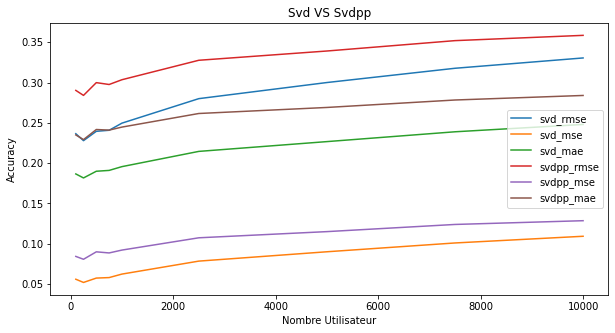

In [16]:
ut.affiche_evaluation_accuracy(nb_user,svd_rmse,svd_mse,svd_mae,svdpp_rmse,svdpp_mse,svdpp_mae)

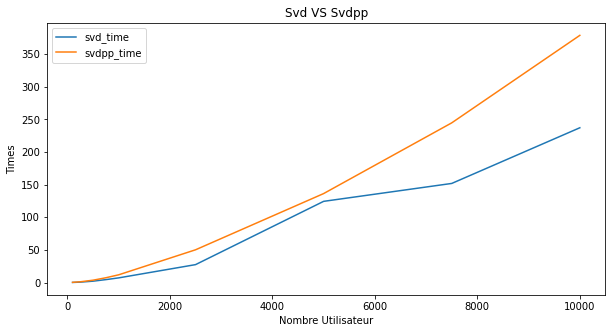

In [17]:
ut.affiche_evaluation_time(nb_user,svd_time,svdpp_time)

Après c'est expérience nous retiendrons que l'algorithme le plus efficace est le SDV.<br/>
Les hyperparamètres les plus efficaces sont : 
    - n_epochs = 20
    - lr_all = 0.005
    - reg_all = 0.02

Filtrage collaboratif qui se base sur les notes des differents utilisateurs aux differentes series pour suggerer a l’utilisateurs les films les plus sucesptibles de lui plaires.<br/>
Les données stockees en memoire sont representé selon 3 colonnes : name_user , movie , rating.<br/>
Nous utilisons cette représentation car les utilisateurs note qu’une minorité de films, ainsi pour optimiser le stockage nous stockerons uniquement les films que l’utilisateur aura noté.

## Entrainement du modele

In [9]:
reco,acc_rmse,acc_mse,acc_mae,predi = fc.filtrage_collaboratif(filtre_collab.iloc[:1000,:],algo,lecteur,verbose=True)

RMSE: 0.2502
MSE: 0.0626
MAE:  0.1958


## Prediction pour les utilisateurs

In [10]:
res = fc.recommandation_user(reco,'razrmaxx73',n=10)

Top Film
1  : breaking bad
2  : the last kingdom
3  : better call saul
4  : bojack horseman
5  : monkeys
6  : friends
7  : schitt s creek
8  : chuck
9  : supernatural
10  : real time with bill maher


In [11]:
res = fc.recommandation_user(reco,'nadyaruray',n=10)

Top Film
1  : breaking bad
2  : the last kingdom
3  : game of thrones
4  : clerks
5  : messiah
6  : better call saul
7  : friends
8  : la la land
9  : chuck
10  : the walking dead


# Filtrage collaboratif (Selection des données)

Prédiction des genres en fonction des utilisateurs<br/>
Afin de sélectionner les profils similaires a notre utilisateurs nous avons mis en place un modele qui sélectionne les genres de serie les préférer par un utilisateurs.

In [13]:
dico = fcg.prediction_n_meilleur_genre(filtre_collab_genre)
res = fcg.recommandation_user(dico,'nadyaruray',limite=4)

Top Genre
1  : drama
2  : action


Pour améliorer nos recommendation en fonction des utilisateurs nous selectionnons les profiles les plus similaires, puis nous appliquons notre algorithmes de recommendation de filtrage collaboratif expliquer dans la section précédente.

In [23]:
user = 'razrmaxx73'

In [24]:
reco, acc_rmse, acc_mse, acc_mae, predi = fc.filtrage_collaboratif2(selectionne_profil,filtre_collab,filtre_collab_genre,user,algo,lecteur,nb_seuil=1000,verbose=False)
res = fc.recommandation_user(reco,user,n=10)

Top Film
1  : the last kingdom
2  : chuck
3  : avatar the last airbender
4  : breaking bad
5  : monkeys
6  : community
7  : k
8  : better call saul
9  : war and peace
10  : schitt s creek


 # Approche baser sur le contenue

In [4]:
(data,nom_serie,nom_episode) = pt.extractionSeries("./t1",normalise=True,filtre=True) 
#sv.sauvegardeFichier("./fichier/base_de_donner_brut_donner_serie",(data,nom_serie,nom_episode))

Suite a l’extraction des données , nous avons sauvegardéles resultats a travers différents fichiers.

In [25]:
serie_1 = sv.lectureFichier("./fichierSerialiser/serie_1")
serie_2 = sv.lectureFichier("./fichierSerialiser/serie_2")
serie_3 = sv.lectureFichier("./fichierSerialiser/serie_3")
serie_4 = sv.lectureFichier("./fichierSerialiser/serie_4") 

In [36]:
liste_nom_serie = serie_1[1]+ serie_2[1] + serie_3[1] + serie_4[1]

In [28]:
stri = ut.constitue_serie_tdidf(serie_1[0]+ serie_2[0] + serie_3[0] + serie_4[0]) #

Nous avons réaliser une grid search afin de trouver les hyperparametres seuil_min et seuil_max les plus intéréssant pour le filtrage de mot.

In [37]:
seuil_min = [0.05,0.1,0.15,0.2,0.25]
seuil_max = [0.75,0.8,0.85,0.9,0.95]

In [29]:
pd_tfidf = cl.TFIDF(stri,seuil_min=0.2,seuil_max=0.75)

In [35]:
tfidf = sv.lectureFichier("./fichierSerialiser/tfidf")

## Mesure de distance

### Correlation de pearson

C:\Users\danse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\danse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


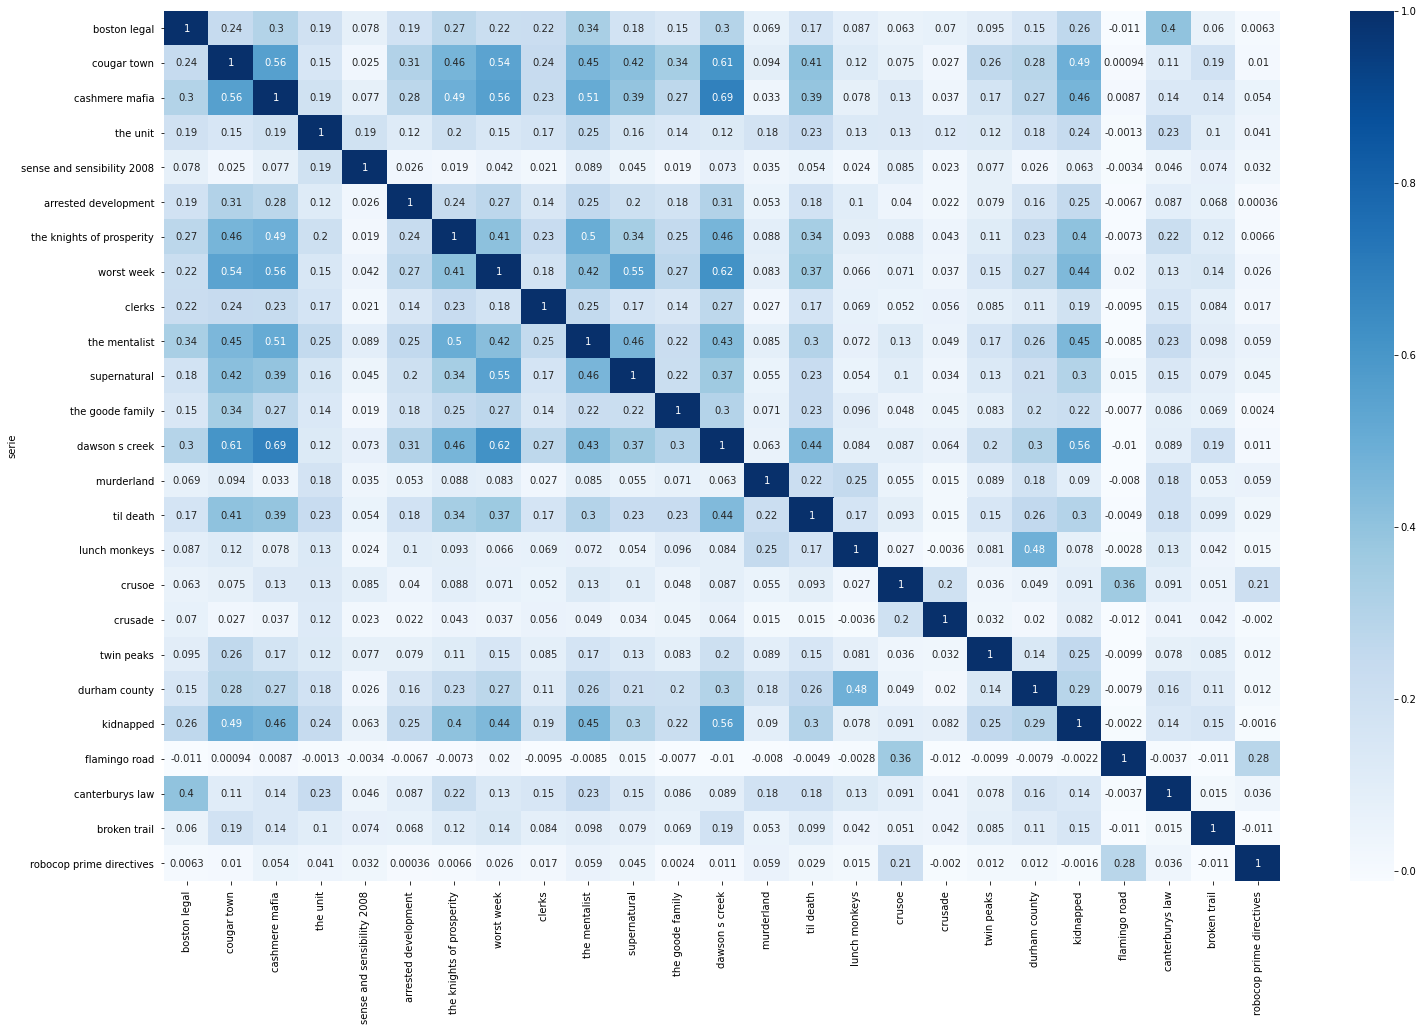

In [38]:
matrice_distance = np.corrcoef(tfidf.to_numpy())
ut.afficheHeatmap(matrice_distance[:25,:25],liste_nom_serie[:25])

### distance euclidienne

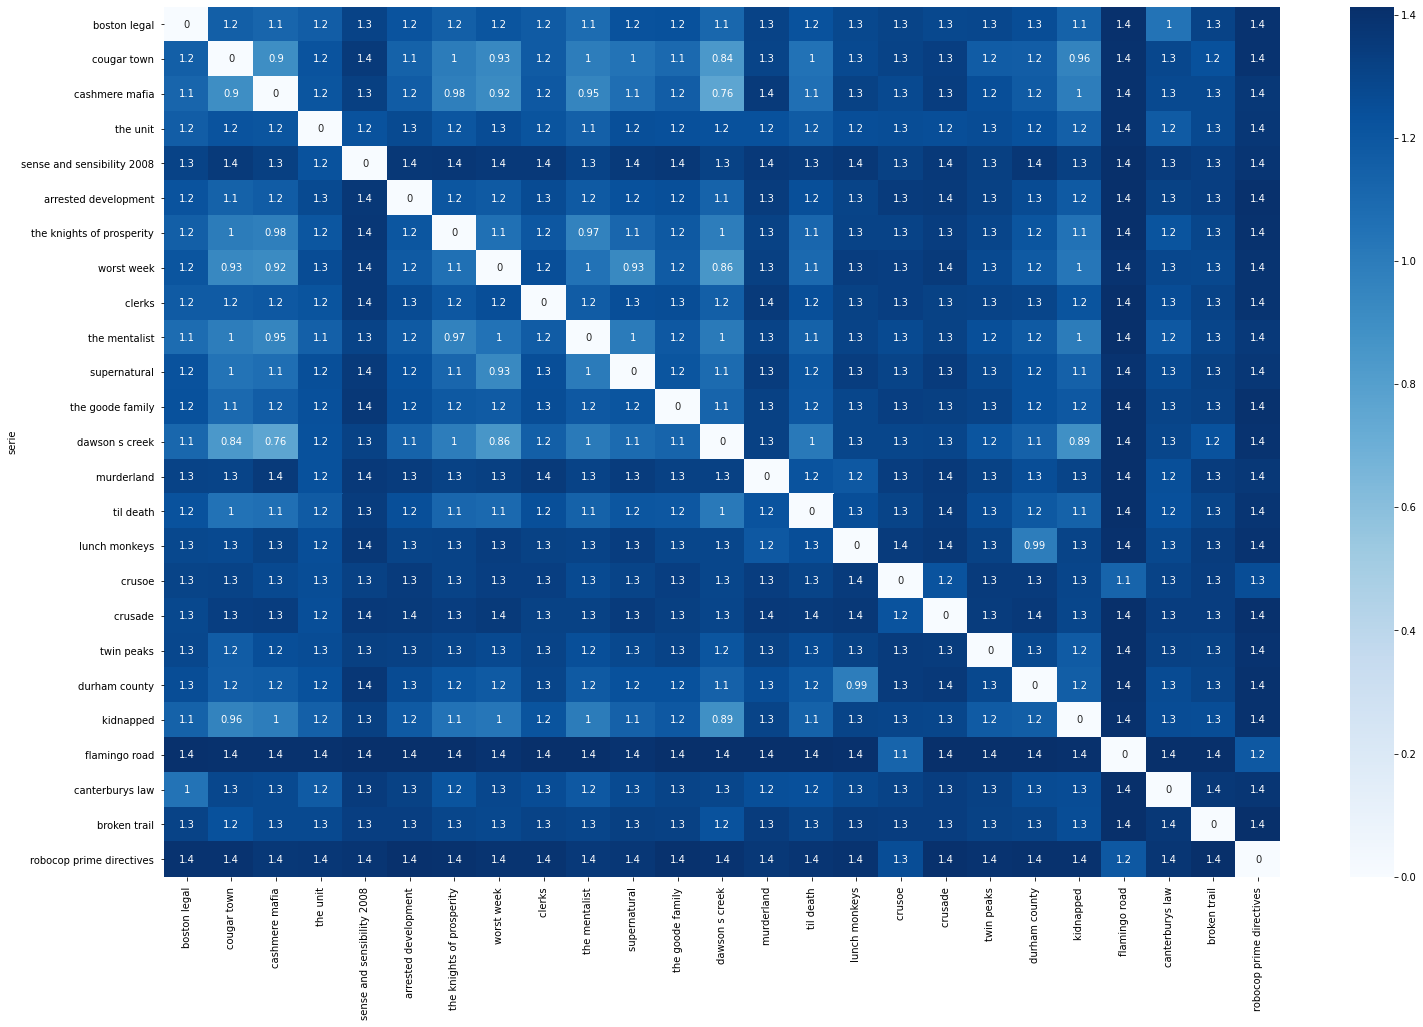

In [39]:
matrice_distance = cl.distance_euclidienne(tfidf)
ut.afficheHeatmap(matrice_distance[:25,:25],liste_nom_serie[:25])

### Distance cosine

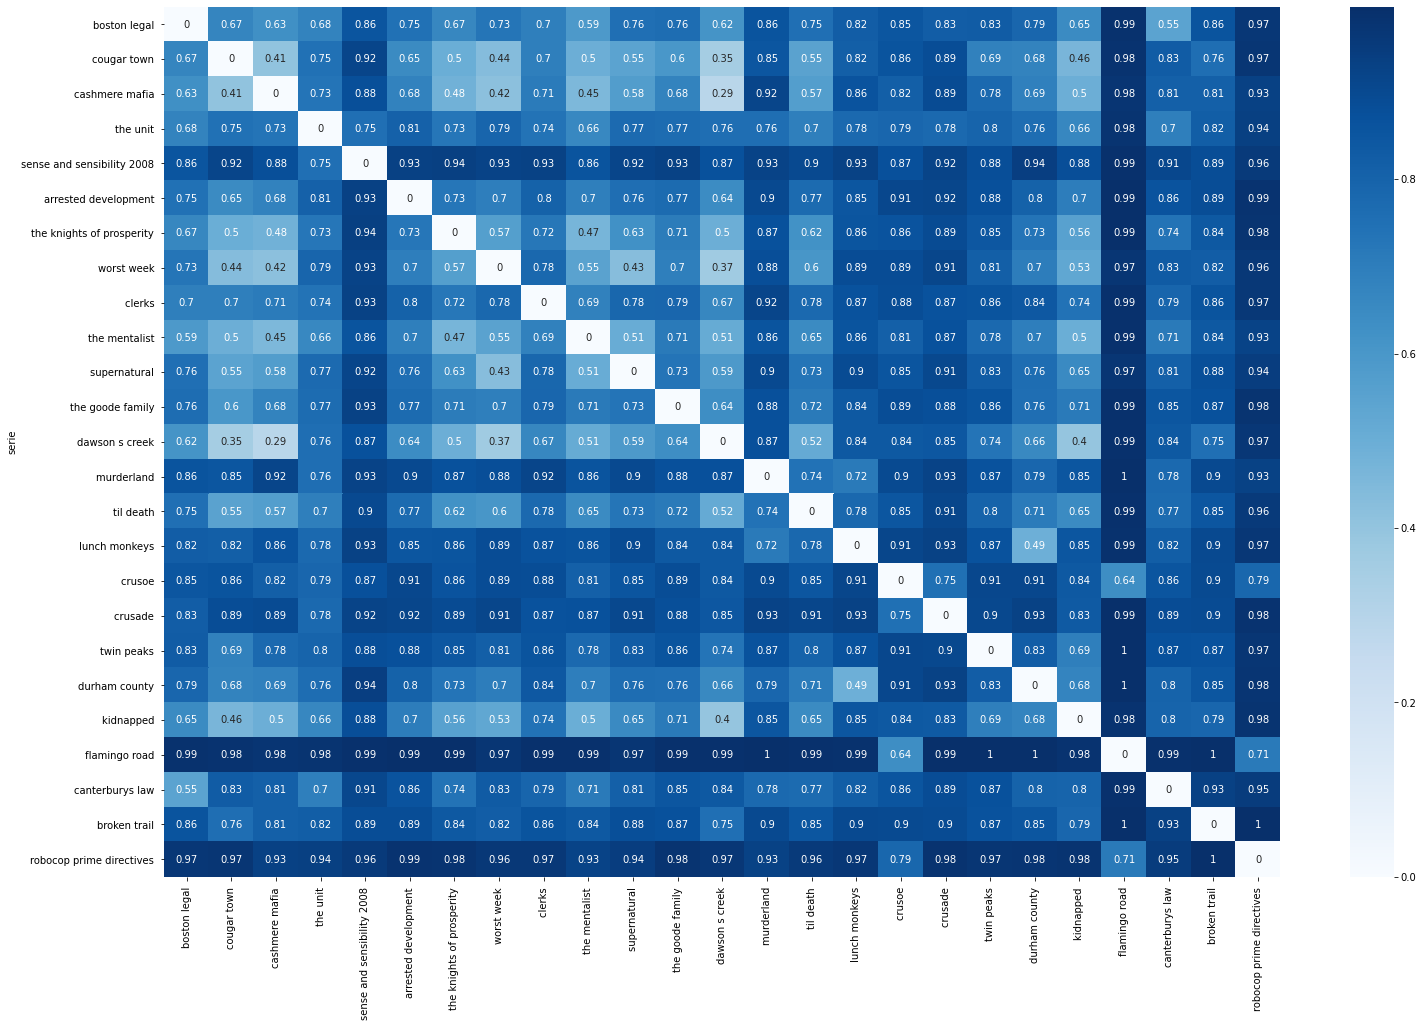

In [40]:
matrice_distance = cl.distance_cosine(tfidf)
ut.afficheHeatmap(matrice_distance[:25,:25],liste_nom_serie[:25])

# Hybridation des différentes approches

In [62]:
res = fc.recommandation_hybride(selectionne_profil,filtre_collab,filtre_collab_genre,user,algo,lecteur,tfidf,liste_nom_serie,nb_seuil=1000,verbose=False)
res 

Top Film
1  : breaking bad
2  : the last kingdom
3  : friends
4  : covert affairs
5  : k


['breaking bad',
 'the last kingdom',
 'friends',
 'covert affairs',
 'k',
 'maron ',
 'rookie blue ',
 'royal pains ',
 'dawson s creek ',
 'svetlana ',
 'parenthood ',
 'chase ',
 '90210 ',
 'i hate my teenage daughter ']

In [ ]:
from prototype import main
main()
